# Google Vision OCR

In [9]:
import requests
import base64
import json
import os
from dotenv import load_dotenv

# .env 파일 읽기
load_dotenv()

# 1. API Key
API_KEY = os.getenv('VISION_API_KEY')

# 2. API URL
VISION_API_URL = f"https://vision.googleapis.com/v1/images:annotate?key={API_KEY}"

# 3. 이미지 로드하고 base64 인코딩
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        content = base64.b64encode(image_file.read()).decode('utf-8')
    return content

# 4. Vision API 요청 보내기
def request_vision_ocr(image_path):
    image_content = encode_image(image_path)
    request_body = {
        "requests": [
            {
                "image": {"content": image_content},
                "features": [{"type": "DOCUMENT_TEXT_DETECTION"}]
            }
        ]
    }
    response = requests.post(VISION_API_URL, json=request_body)
    return response.json()

# 5. 결과 가져오기
image_path = "../documents/직원대출신청서_5개모음집_pages-to-jpg-0001.jpg"
vision_result = request_vision_ocr(image_path)

# 6. OCR 결과 확인
print(vision_result)

# 결과 확인
annotations = vision_result['responses'][0]['textAnnotations']
for ann in annotations[1:]:
    print(ann['description'])
    print(ann['boundingPoly']['vertices'])

{'responses': [{'textAnnotations': [{'locale': 'ko', 'description': '접수번호 ※\n직원 대출신청서\n20250401\n담당\n성 명\n김하늘\n인적\n생년월일\n1992-06-15\n소속/직위\n전화번호\n마케팅팀/ 대리\n사항\n010-1234 5678\n주 소\n서울특별시 강남구 테헤란로 123\n입사일자\n2018년 3월 1일\n실 근속년수\n6년 1개월\n신청금액\n일금 삼백만\n원정(₩ 3,000,000\n의료비\n자금용도\n대출기일\n2025년 05월1일\n상환예정일\n2026년05월1일\n무담보\n담보(보증) 여건\n상기 본인은 직원대출을 받고자 신청합니다.\n2025년04월22일\n주식회사 ㅇㅇ\n위 신청인: 김하늘\n(인)', 'boundingPoly': {'vertices': [{'x': 156, 'y': 150}, {'x': 1085, 'y': 150}, {'x': 1085, 'y': 1599}, {'x': 156, 'y': 1599}]}}, {'description': '접수', 'boundingPoly': {'vertices': [{'x': 197, 'y': 308}, {'x': 231, 'y': 308}, {'x': 231, 'y': 325}, {'x': 197, 'y': 325}]}}, {'description': '번호', 'boundingPoly': {'vertices': [{'x': 235, 'y': 308}, {'x': 267, 'y': 308}, {'x': 267, 'y': 325}, {'x': 235, 'y': 325}]}}, {'description': '※', 'boundingPoly': {'vertices': [{'x': 280, 'y': 308}, {'x': 293, 'y': 308}, {'x': 293, 'y': 325}, {'x': 280, 'y': 325}]}}, {'description': '직원', 'boundingPoly': {'vertices': [

# 필드 자동 매칭하는 로직

In [12]:
# field_template_boxes.json 로딩
with open('./field_template_boxes.json', 'r', encoding='utf-8') as f:
    field_template = json.load(f)

# 결과 초기화
extracted_fields = {field: {"text": "", "confidence": 0.0} for field in field_template.keys()}

# 박스 안에 들어가는지 체크
def is_inside(box, point):
    x_min = min(box['top_left'][0], box['bottom_left'][0])
    x_max = max(box['top_right'][0], box['bottom_right'][0])
    y_min = min(box['top_left'][1], box['top_right'][1])
    y_max = max(box['bottom_left'][1], box['bottom_right'][1])
    x, y = point
    return x_min <= x <= x_max and y_min <= y <= y_max

# OCR 결과로 필드 매칭
for ann in annotations[1:]:  # [0]은 전체 텍스트
    description = ann['description']
    vertices = ann['boundingPoly']['vertices']
    
    # 중심점 계산
    center_x = int(sum([v['x'] for v in vertices]) / 4)
    center_y = int(sum([v['y'] for v in vertices]) / 4)
    center_point = (center_x, center_y)

    for field_name, field_box in field_template.items():
        if is_inside(field_box, center_point):
            if extracted_fields[field_name]["text"]:
                extracted_fields[field_name]["text"] += " " + description
            else:
                extracted_fields[field_name]["text"] = description
            break

# 최종 결과 출력
print("\n✅ 최종 매칭 결과:")
for field, info in extracted_fields.items():
    print(f"{field}: {info['text']}")


✅ 최종 매칭 결과:
접수번호: 20250401
성명: 김하늘
소속/지위: 마케팅 팀 / 대리
생년월일: 1992-06-15
전화번호: 010-1234 5678
주소: 서울 특별시 강남구 테헤란로 123
입사일자: 2018 년 3 월 1 일
실 근속년수: 6 년 1 개월
신청금액: 일금 삼백 만 원정 ( ₩ 3,000,000
자금용도: 의료비
대출기일: 2025 년 05 월 1 일
상환예정일: 2026 년 05 월 1 일
담보(보증)여건: 무담보
신청일: 2025 년 04 월 22 일
신청인: 김하늘


# 확인용으로 Google Vision API 박스 영역 시각화

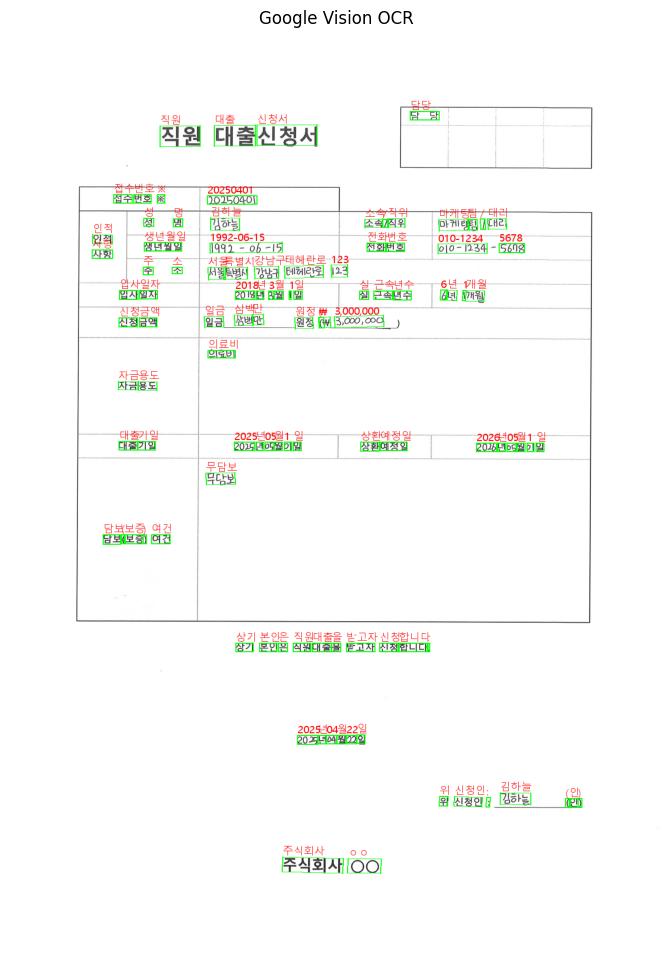

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# === 이미지 로드
image = Image.open(image_path).convert('RGB')
draw = ImageDraw.Draw(image)

# 한글 폰트 (필수!)
font_path = "C:/Windows/Fonts/malgun.ttf"
font = ImageFont.truetype(font_path, size=20)

# === Vision OCR 결과를 돌면서 박스 그리기
for ann in annotations[1:]:  # annotations는 vision_result['responses'][0]['textAnnotations']
    vertices = ann['boundingPoly']['vertices']
    text = ann['description']

    # 박스 좌표
    pts = [(v.get('x', 0), v.get('y', 0)) for v in vertices]

    # 박스 그리기
    draw.line(pts + [pts[0]], width=2, fill=(0, 255, 0))

    # 텍스트 쓰기 (박스 왼쪽 위에)
    draw.text((pts[0][0], pts[0][1] - 25), text, font=font, fill=(255, 0, 0))

# === 결과 보여주기
plt.figure(figsize=(12, 12))
plt.imshow(np.array(image))
plt.axis('off')
plt.title("Google Vision OCR")
plt.show()